In [1]:
! pip install -q nnAudio librosa hsluv

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sb

from transformers import Wav2Vec2FeatureExtractor
from transformers import AutoModel
import torch
from torch import nn
import torchaudio.transforms as T
from datasets import load_dataset

import librosa 
import scipy.io.wavfile
import hsluv

# Neural Features

Distill / fine-tune embedding knowledge from a large domain general pretrained Model into a smaller domain specific model 

## Get embedding from music backbone (m-a-p/MERT-v1-95M)

### encode sample music file

In [ ]:


audio_file = '/kaggle/input/private-dancumortilor-wav/dancu.wav'

duration = librosa.get_duration(path=audio_file)
duration

from IPython.display import Audio
Audio(audio_file)


KeyboardInterrupt



In [ ]:
## see https://huggingface.co/m-a-p/MERT-v1-95M


mert = AutoModel.from_pretrained("m-a-p/MERT-v1-95M", trust_remote_code=True)  # loading our model weights
processor = Wav2Vec2FeatureExtractor.from_pretrained("m-a-p/MERT-v1-95M",trust_remote_code=True)  # loading the corresponding preprocessor config


sampling_rate, input_audio = scipy.io.wavfile.read(audio_file)
input_audio = torch.tensor(input_audio).float().mean(1)
    

resample_rate = processor.sampling_rate
if resample_rate != sampling_rate:  # make sure the sample_rate aligned
      print(f'setting rate from {sampling_rate} to {resample_rate}')
      resampler = T.Resample(sampling_rate, resample_rate)
else: resampler = None
    

# audio file is decoded on the fly
if resampler is None:   input_audio = input_audio
else:                   input_audio = resampler(input_audio)
  

inputs = processor(input_audio, sampling_rate=resample_rate, return_tensors="pt")
mert.eval()
with torch.no_grad():
    outputs = mert(**inputs, output_hidden_states=True)

In [9]:
# take a look at the output shape, there are 13 layers of representation
# each layer performs differently in different downstream tasks, you should choose empirically
mertfs = torch.stack(outputs.hidden_states).squeeze().permute((1,0,2)).cuda()

print(mertfs.shape)

!mkdir -p cache
torch.save(mertfs, 'cache/features.pt')

NameError: name 'outputs' is not defined

## Define Autoencoder for knowledge compression 

In [14]:
mertfs = torch.load('cache/features.pt')
mertfs.shape, mertfs.min(), mertfs.max()

(torch.Size([9537, 13, 768]),
 tensor(-10.7027, device='cuda:0'),
 tensor(5.9936, device='cuda:0'))

In [15]:
import torch
from torch import nn
import numpy as np

layers = np.linspace(mertfs.shape[2], 6, 2 +  1  ).astype(int)
                                # hidden layers ↑
layers = list(zip(layers, layers[1:]))

class Trace(nn.Module):
    def __init__(self):
        super(Trace, self).__init__()
    def forward(self, x): 
        #print(x.shape)
        return x


make_mlp = lambda ls: nn.Sequential(*[nn.Sequential( Trace(),
    nn.Linear(i,o), nn.ReLU(), nn.BatchNorm1d(o), Trace()
    ) for i,o in ls])


## see https://avandekleut.github.io/vae/

class VariationalEncoder(nn.Module):
    def __init__(self, layers):
        super(VariationalEncoder, self).__init__()
        
        self.aggregate = nn.Sequential(
            nn.Conv1d(in_channels=13, out_channels=1, kernel_size=1),
            nn.Flatten(1,2))
        self.shared = make_mlp(layers[:-1])
        self.mu = nn.Linear(*layers[-1])
        self.sigma = nn.Linear(*layers[-1])

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        #x = torch.flatten(x, start_dim=1)
        x = self.aggregate(x)
        x = self.shared(x)
        mu =  self.mu(x)
        sigma = torch.exp(self.sigma(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z


class Decoder(nn.Module):
    def __init__(self, layers):
        super(Decoder, self).__init__()

        self.net = nn.Sequential(
            make_mlp(layers),
            nn.Unflatten(1, [1, mertfs.shape[2]]),
            nn.Conv1d(in_channels=1, out_channels=13, kernel_size=1),
            )

    def forward(self, z): return self.net(z)
    # consider an activation function like torch.Sigmoid or so


class Autoencoder(nn.Module):
    def __init__(self, layers):
        super(Autoencoder, self).__init__()
        self.encoder = VariationalEncoder(layers)
        self.decoder = Decoder([(o,i) for i,o in layers[::-1]])

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


model = Autoencoder(layers).cuda()
print(model)

Autoencoder(
  (encoder): VariationalEncoder(
    (aggregate): Sequential(
      (0): Conv1d(13, 1, kernel_size=(1,), stride=(1,))
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (shared): Sequential(
      (0): Sequential(
        (0): Trace()
        (1): Linear(in_features=768, out_features=387, bias=True)
        (2): ReLU()
        (3): BatchNorm1d(387, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Trace()
      )
    )
    (mu): Linear(in_features=387, out_features=6, bias=True)
    (sigma): Linear(in_features=387, out_features=6, bias=True)
  )
  (decoder): Decoder(
    (net): Sequential(
      (0): Sequential(
        (0): Sequential(
          (0): Trace()
          (1): Linear(in_features=6, out_features=387, bias=True)
          (2): ReLU()
          (3): BatchNorm1d(387, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): Trace()
        )
        (1): Sequential(
          (0): Trace()
          (1): Linear(in_

In [33]:
model = Autoencoder(layers).cuda()
for xx in training_loader:
    yy = model(xx)
    print(yy.shape, yy.min(), yy.max())

torch.Size([8584, 13, 768]) tensor(-19.9462, device='cuda:0', grad_fn=<MinBackward1>) tensor(21.4542, device='cuda:0', grad_fn=<MaxBackward1>)


## Train the knowledge compression

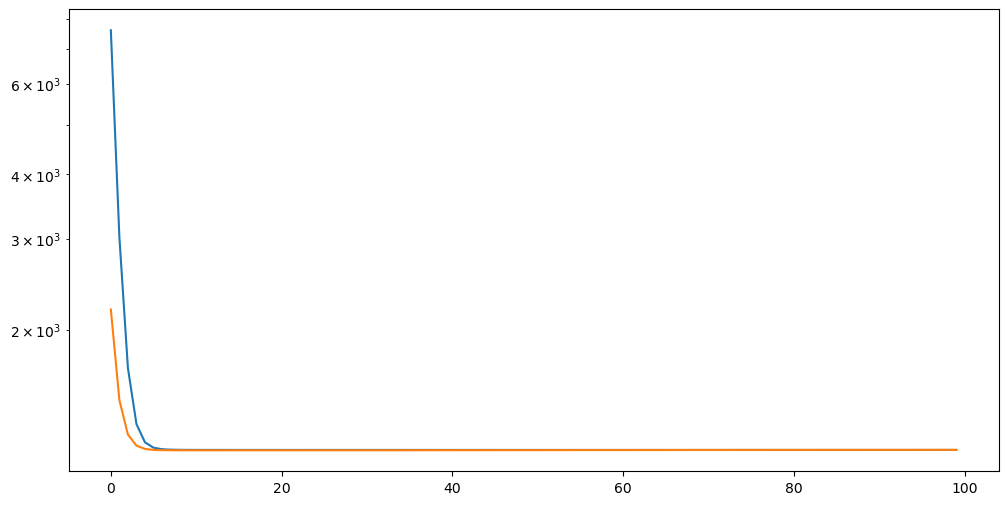

1167.7569580078125 1168.087646484375


In [17]:
traindata, valdata = torch.utils.data.random_split(mertfs, [0.9, 0.1])
## TODO verfify overfit on a single frame

BS = mertfs.shape[0]
training_loader = torch.utils.data.DataLoader(traindata, batch_size=BS, shuffle=False)
validation_loader = torch.utils.data.DataLoader(valdata, batch_size=BS, shuffle=False)

losses = []
losses_val = []

model = Autoencoder(layers).cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # for all other scenarios 20 was best


LOSS = lambda x,x_hat: (model.encoder.kl + ((x - x_hat)**2).sum()) / x.shape[0]   # NOTE this last normalization term makes the losses not go nan instantly 

def train():
    for e in range(Epochs):
        model.train(True)
        
        for xx in training_loader:
            optimizer.zero_grad()
            
            loss = LOSS(xx, model(xx))
            losses.append (loss.item())
        
            loss.backward()
            
            optimizer.step()
        scheduler.step()

        model.train(False)
        for xx in validation_loader:
            losses_val.append(LOSS(xx, model(xx)).item())

        clear_output(wait=True)
        fig, ax= plt.subplots(1, 1, figsize=(12, 6))
        ax.plot(np.linspace(0,e,len(losses    )), losses)
        ax.plot(np.linspace(0,e,len(losses_val)), losses_val)
        plt.yscale("log")
        plt.show()

Epochs = 100

train()
print(losses[-1], losses_val[-1])

## Render the latents to a simple visualization

In [22]:
model.eval()
with torch.no_grad(): 
    target = model.encoder(mertfs).cpu().numpy()

print(target.shape, target.min(), target.max())
print(target.min(0).shape)
    
target -= target.min(0)
print(target.shape, target.min(), target.max())
target /= target.max(0)
targte = target*2 -1
print(target.shape, target.min(), target.max())

(9537, 6) -9.6208 7.0441957
(6,)
(9537, 6) 0.0 16.664995
(9537, 6) 0.0 1.0


In [ ]:
%%capture

! mkdir -p cache/framebuff


def target_domain(hmin=0, hmax=360, mmin=-1, mmax=1, lmin=0, lmax=100):
    def mod2trg(h,l):
        h = (h-mmin)/(mmax-mmin)
        l = (l-mmin)/(mmax-mmin)
        return h * (hmax-hmin) + hmin, 100, l*(lmax-lmin)+lmin
        
    def trg2mod(H,L,S=100):
        H = (H-hmin)/(hmax-hmin)
        L = (L-lmin)/(lmax-lmin)
        return H * (mmax-mmin) + mmin, L * (mmax-mmin) + mmin

    return mod2trg, trg2mod

m2hsl, hl2m = target_domain(hmin=0, hmax=360, lmin=0, lmax=70)

def render_frames(target):
    for i,pred_i in enumerate(target):
        out = np.zeros((9,9,3))
        
        hs = pred_i[0::2]
        ls = pred_i[1::2]
        dots = zip([(2,2),(2,6),(5,4)], hs, ls)
        
        for (x,y), h,l in dots:
            out[x,y] = hsluv.hsluv_to_rgb(m2hsl(h,l))
        
        fig = plt.figure(figsize = (1,1))
        fig.patch.set_facecolor('black')
        plt.axis('off')
        plt.imshow(out, aspect='equal', interpolation='sinc', interpolation_stage='rgba');
        plt.savefig(f'cache/framebuff/{i:05d}', dpi=32)
    
    
frames = target[::]
render_frames(frames)

In [ ]:
! mkdir -p render
! rm render/dancu-v3.mp4 
# see https://stackoverflow.com/questions/14782077/expand-extend-a-video-to-an-specific-duration
! ffmpeg -i cache/framebuff/%05d.png -i {audio_file} -filter_complex "[0:v]setpts=PTS*{duration}/{len(frames)/(FPS:=25)}[v]" -map "[v]" -map 1:a -shortest render/dancu-v3.mp4 

#! rm -r cache/framebuff